In [65]:
# Imports
import pandas as pd
import numpy as np
import doubleml as dml
from doubleml.datasets import fetch_401K

import torch
import os
import time
from functools import partial

# Causal_cocycle imports
from causal_cocycle.kernels_new import GaussianKernel
from causal_cocycle.distribution_estimation import ConditionalExpectationRegressor  # :contentReference[oaicite:5]{index=5}
from causal_cocycle.regression_functionals import NWFunctional
from causal_cocycle.loss_factory import CocycleLossFactory
from causal_cocycle.kernels import gaussian_kernel
from causal_cocycle.conditioners_new import NWConditioner  # NWConditioner defined earlier
from causal_cocycle.transformers_new import KREpsLayer  # Your KR transformer layer
from causal_cocycle.model_new import CocycleModel   # Your CocycleModel class
from e401k_cocycle_config import model_config, opt_config

In [66]:
# Getting data and names
Data = fetch_401K(return_type='DataFrame')
data = Data.to_numpy()
names = np.array(list(Data[:0]))

In [73]:
"""
Data processing
"""

# Names
covariates = ['age', 'inc', 'educ', 'fsize', 'marr',
                 'twoearn', 'db', 'pira', 'hown', 'e401']
treatment = ["e401"]
outcome = ["net_tfa"]

# Creating tensors
X = Data[Data.columns.intersection(covariates)]
names_x = np.array(list(X[:0]))
treatment_ind = np.where(names_x == "e401")[0][0]
X = X.to_numpy()
cols_order = ([treatment_ind]+
              list(np.linspace(0,treatment_ind-1,treatment_ind).astype(int))+
              list(np.linspace(treatment_ind+1,len(X.T)-1,len(X.T)-1-treatment_ind).astype(int)))
X = X[:,cols_order]
N = len(X)
D = len(X.T)
Y = Data[Data.columns.intersection(outcome)].to_numpy().reshape(N,)
X,Y = torch.tensor(X),torch.tensor(Y).view(N,1)
print("# treated = ", int(X[:,0].sum()), "/", N)

# Scaling data
scale_X = torch.ones(len(X.T))
for i in range(len(X.T)):
    if len(torch.unique(X[:,i])) > 2:
        scale_X[i] = X[:,i].var(0)**0.5
scale_Y = Y.var(0)**0.5
Xscale,Yscale = X/scale_X, Y/scale_Y

# Random dataset shuffle
id = torch.randperm(Xscale.size(0))
Xscale,Yscale = Xscale[id].double(),Yscale[id].double()

# Train validation split
train_pc = 0.7
ntrain = int(train_pc * N)
Xtr, Ytr = Xscale[:ntrain], Yscale[:ntrain]
Xte, Yte = Xscale[ntrain:], Yscale[ntrain:]

Xscale.mean(0), Yscale.mean()

# treated =  3682 / 9915


(tensor([0.3714, 3.9693, 1.5016, 1.8622, 4.6991, 0.2710, 0.6048, 0.3808, 0.2422,
         0.6352], dtype=torch.float64),
 tensor(0.2842, dtype=torch.float64))

In [69]:
"""
Conditional CDF estimation
"""
kernel = GaussianKernel(lengthscale=torch.ones(D)/ D**0.5)
functional = NWFunctional(kernel=kernel, reg=0.0)
CER = ConditionalExpectationRegressor(functional)
print("Starting hyperparameter optimisation...")
test_points = torch.quantile(Ytr, torch.linspace(0,1,100))
feature = (Ytr <= test_points.T).float()
losses = CER.optimise(Xtr, feature, maxiter=1000, nfold=5, learn_rate=1e-1, print_=True, subsamples = 256)

Starting hyperparameter optimisation...
[iter 0] avg CV loss: 0.196168
lengthscale: tensor([0.3495, 0.3495, 0.3495, 0.3495, 0.3495, 0.3495, 0.3495, 0.3495, 0.2861,
        0.3495], grad_fn=<ExpBackward0>)
[iter 10] avg CV loss: 0.126929
lengthscale: tensor([0.8140, 0.9055, 0.8835, 0.9033, 0.8816, 0.8983, 0.8802, 0.8841, 0.2677,
        0.8445], grad_fn=<ExpBackward0>)
[iter 20] avg CV loss: 0.125542
lengthscale: tensor([0.9427, 1.5063, 1.1396, 1.6322, 1.5414, 1.4679, 1.4951, 1.4676, 0.3209,
        1.1987], grad_fn=<ExpBackward0>)
[iter 30] avg CV loss: 0.124456
lengthscale: tensor([0.6988, 1.5759, 0.8112, 2.0498, 1.9099, 1.7726, 1.8577, 1.8005, 0.4263,
        1.1901], grad_fn=<ExpBackward0>)
[iter 40] avg CV loss: 0.122426
lengthscale: tensor([0.5008, 1.3346, 0.6363, 2.1799, 2.0507, 1.9070, 2.0422, 1.9273, 0.3821,
        1.0358], grad_fn=<ExpBackward0>)
[iter 50] avg CV loss: 0.121734
lengthscale: tensor([0.5020, 1.1057, 0.7025, 2.1748, 2.0971, 1.9608, 2.1437, 1.9442, 0.3997,
      

In [70]:
"""
KRcocycle construction + loss for CMMD
"""

# Getting sorted data + epsilon
Ysort,ids = torch.sort(Ytr.squeeze().double())
Xsort = Xtr[ids].double()
diff_unique = (Ysort[1:] - Ysort[:-1]).unique()
epsilon = min(1e-6, (diff_unique)[diff_unique!=0].min()/10)
print(epsilon)

# Construct cocycle model
conditioner = NWConditioner(Xsort, kernel)
transformer = KREpsLayer(Ysort , epsilon)
model = CocycleModel(conditioner=conditioner, transformer=transformer)

# Construct loss
kernel_loss = [gaussian_kernel()] * 2
loss_factory = CocycleLossFactory(kernel_loss)
loss = loss_factory.build_loss("CMMD_V", Ytr, Ytr, subsamples=10**4)

1e-06


In [72]:
"""
Getting validation loss on test data
"""
def cmmd_embedding_loss_vectorized(model, X, Y, kernel, batchsize=10):
    """
    Fully vectorized CMMD loss with batch processing over i.

    Args:
        model: with .inverse_transformation(X, Y), .transformation(X, Z)
        X: (n, d)
        Y: (n, p)
        kernel: with get_gram(A, B)
        batchsize: outer batch size

    Returns:
        scalar CMMD loss
    """
    import torch, gc, psutil, os

    n = X.shape[0]
    device = X.device
    total_loss = 0.0

    # Step 1: precompute base latent samples Z = f^{-1}_{x_j}(Y_j)
    print("Precomputing inverse-transformed base samples...")
    with torch.no_grad():
        Z_base = model.inverse_transformation(X, Y).detach()  # shape: (n, p)

    for i_start in range(0, n, batchsize):
        i_end = min(i_start + batchsize, n)
        b = i_end - i_start

        X_i = X[i_start:i_end]      # shape: (b, d)
        Y_i = Y[i_start:i_end]      # shape: (b, p)

        # Step 2: expand X_i to match (b x n) for transformation
        X_i_repeat = X_i[:, None, :].repeat(1, n, 1).reshape(b * n, -1)   # (b*n, d)
        Z_repeat = Z_base[None, :, :].repeat(b, 1, 1).reshape(b * n, -1)  # (b*n, p)

        # Step 3: transform → Y_hat[i, j, :] = f_{x_i}(Z_j)
        with torch.no_grad():
            Y_hat = model.transformation(X_i_repeat, Z_repeat).detach().reshape(b, n, -1)  # (b, n, p)

        # Step 4: Compute CMMD loss terms vectorized
        k_yy_diag = torch.diagonal(kernel.get_gram(Y_i, Y_i))  # (b,)
        k_y_hat = torch.stack([
            kernel.get_gram(Y_i[i:i+1], Y_hat[i]).mean()
            for i in range(b)
        ])
        k_hat_hat = torch.stack([
            kernel.get_gram(Y_hat[i], Y_hat[i]).mean()
            for i in range(b)
        ])

        loss_batch = k_yy_diag + k_hat_hat - 2 * k_y_hat
        total_loss += loss_batch.sum()

        mem_MB = psutil.Process(os.getpid()).memory_info().rss / 1e6
        print(f"[{i_end}/{n}] Memory used (MB): {mem_MB:.2f}")
        gc.collect()
        torch.cuda.empty_cache()

    return total_loss / n


cmmd = cmmd_embedding_loss_vectorized(model,Xte.double(),Yte.double(),loss.kernel[-1])
print("CMMD is ", cmmd)

Precomputing inverse-transformed base samples...
[10/2975] Memory used (MB): 698.77
[20/2975] Memory used (MB): 700.21
[30/2975] Memory used (MB): 699.90
[40/2975] Memory used (MB): 700.06
[50/2975] Memory used (MB): 703.59
[60/2975] Memory used (MB): 697.46
[70/2975] Memory used (MB): 701.73
[80/2975] Memory used (MB): 703.31
[90/2975] Memory used (MB): 700.47
[100/2975] Memory used (MB): 703.83
[110/2975] Memory used (MB): 701.18
[120/2975] Memory used (MB): 703.31
[130/2975] Memory used (MB): 699.39
[140/2975] Memory used (MB): 703.12
[150/2975] Memory used (MB): 698.87
[160/2975] Memory used (MB): 706.05
[170/2975] Memory used (MB): 699.27
[180/2975] Memory used (MB): 703.02
[190/2975] Memory used (MB): 701.67
[200/2975] Memory used (MB): 701.69
[210/2975] Memory used (MB): 698.22
[220/2975] Memory used (MB): 699.36
[230/2975] Memory used (MB): 700.96
[240/2975] Memory used (MB): 702.53
[250/2975] Memory used (MB): 701.42
[260/2975] Memory used (MB): 701.69
[270/2975] Memory used (

In [75]:
"""
Fitting final model on full data
"""
kernel = GaussianKernel(lengthscale=torch.ones(D)/ D**0.5)
functional = NWFunctional(kernel=kernel, reg=0.0)
CER = ConditionalExpectationRegressor(functional)
print("Starting hyperparameter optimisation...")
test_points = torch.quantile(Yscale, torch.linspace(0,1,100, dtype = torch.float64))
feature = (Yscale <= test_points.T).float()
losses = CER.optimise(Xscale, feature, maxiter=1000, nfold=5, learn_rate=1e-1, print_=True, subsamples = 256)

# Getting sorted data + epsilon
Ysort,ids = torch.sort(Yscale.squeeze().double())
Xsort = Xscale[ids].double()
diff_unique = (Ysort[1:] - Ysort[:-1]).unique()
epsilon = min(1e-6, (diff_unique)[diff_unique!=0].min()/10)
print(epsilon)

# Construct final model
conditioner = NWConditioner(Xsort, kernel)
transformer = KREpsLayer(Ysort , epsilon)
model = CocycleModel(conditioner=conditioner, transformer=transformer)

Starting hyperparameter optimisation...
[iter 0] avg CV loss: 0.196984
lengthscale: tensor([0.3495, 0.3495, 0.3495, 0.3495, 0.3495, 0.3495, 0.3495, 0.3495, 0.2861,
        0.3495], grad_fn=<ExpBackward0>)
[iter 10] avg CV loss: 0.127267
lengthscale: tensor([0.8327, 0.9063, 0.8904, 0.9030, 0.8891, 0.8885, 0.9055, 0.8953, 0.2188,
        0.8537], grad_fn=<ExpBackward0>)
[iter 20] avg CV loss: 0.125419
lengthscale: tensor([0.9116, 1.4949, 1.0980, 1.5875, 1.5846, 1.4399, 1.5531, 1.4916, 0.2085,
        1.1839], grad_fn=<ExpBackward0>)
[iter 30] avg CV loss: 0.122914
lengthscale: tensor([0.6234, 1.5620, 0.7154, 2.0064, 2.0131, 1.7508, 1.9475, 1.8419, 0.2051,
        1.1706], grad_fn=<ExpBackward0>)
[iter 40] avg CV loss: 0.124052
lengthscale: tensor([0.4817, 1.3389, 0.5906, 2.1901, 2.2155, 1.8980, 2.1590, 1.9866, 0.2034,
        1.0557], grad_fn=<ExpBackward0>)
[iter 50] avg CV loss: 0.121770
lengthscale: tensor([0.5381, 1.1568, 0.7555, 2.2410, 2.2935, 1.9692, 2.2892, 2.0168, 0.2036,
      

NameError: name 'final_model_overall' is not defined

In [76]:
"""
Getting predictions
"""
X0scale,X1scale = Xscale*1,Xscale*1
X0scale[:,0] = 0
X1scale[:,0] = 1
Y0scale = model.cocycle(X0scale,Xscale,Yscale).detach()
Y1scale = model.cocycle(X1scale,Xscale,Yscale).detach()

ATE = (Y1scale-Y0scale).mean()*scale_Y
ATT = (Y1scale[Xscale[:,0]==1]-Y0scale[Xscale[:,0]==1]).mean()*scale_Y
print("ATE : ", ATE.item())
print("ATT : ", ATT.item())

ATE :  6029.69677734375
ATT :  8493.060546875


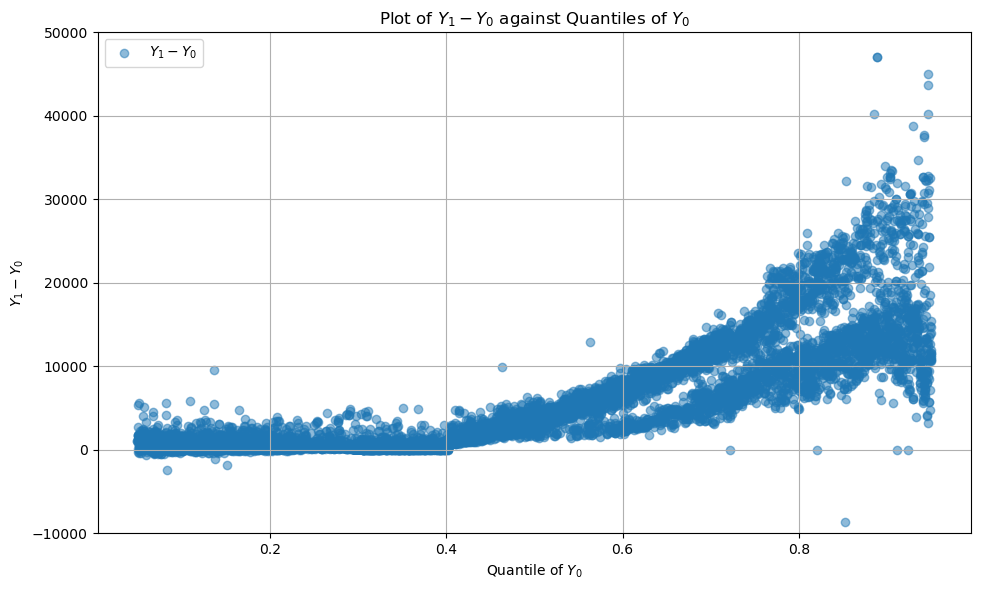

In [79]:
"""
Quantile plot
"""
import numpy as np
import matplotlib.pyplot as plt

# Assume Y0scale and Y1scale are 1D numpy arrays of equal length
Y_diff = (Y1scale - Y0scale)

# Step 1: Sort Y0scale and get corresponding sorted Y_diff
sort_idx = np.argsort(Y0scale.squeeze(-1))
Y0_sorted = Y0scale[sort_idx]
Y_diff_sorted = Y_diff[sort_idx]

# Step 2: Compute quantile positions (from 0 to 1)
n = len(Y0scale)
quantile_positions = np.linspace(0, 1, n)

# Step 3: Plot
plt.figure(figsize=(10, 6))
l = int(n/20)
plt.scatter(quantile_positions[l:n-l], Y_diff_sorted[l:n-l]*scale_Y, label="$Y_1 - Y_0$", alpha = 0.5)
plt.xlabel("Quantile of $Y_0$")
plt.ylabel("$Y_1 - Y_0$")
plt.title("Plot of $Y_1 - Y_0$ against Quantiles of $Y_0$")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.ylim(-10000,50000)
plt.show()

Text(0, 0.5, 'Y1-Y0')

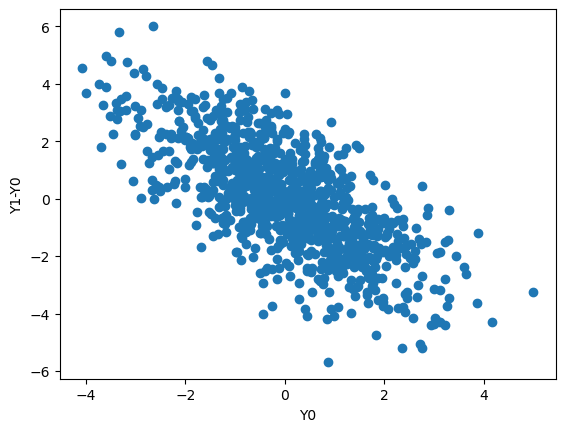

In [132]:
m=1000
x = Normal(0,1).sample((m,))
u = Normal(0,1).sample((m,))
y1 = x+u
y0 = -x + u
plt.scatter(y0,y1-y0)
plt.xlabel("Y0")
plt.ylabel("Y1-Y0")

In [83]:
"""
Train NW functional for conditional distribution 
"""

kernel_ = GaussianKernel(lengthscale=torch.ones(1))
functional_ = NWFunctional(kernel=kernel_, reg=0.0)
CER_ = ConditionalExpectationRegressor(functional_)
print("Starting hyperparameter optimisation...")
test_points_ = torch.quantile(Y1scale - Y0scale, torch.linspace(0,1,100, dtype = torch.float64))
feature_ = ((Y1scale - Y0scale).unsqueeze(-1)<= test_points_.unsqueeze(0)).float()
losses = CER_.optimise(Y0scale.unsqueeze(-1), feature_, maxiter=1000, nfold=5, learn_rate=1e-1, print_=True, subsamples = 256)

Starting hyperparameter optimisation...
[iter 0] avg CV loss: 0.157372
lengthscale: tensor([0.9048], grad_fn=<ExpBackward0>)
[iter 10] avg CV loss: 0.138568
lengthscale: tensor([0.3267], grad_fn=<ExpBackward0>)
[iter 20] avg CV loss: 0.113897
lengthscale: tensor([0.1136], grad_fn=<ExpBackward0>)
[iter 30] avg CV loss: 0.096502
lengthscale: tensor([0.0431], grad_fn=<ExpBackward0>)
[iter 40] avg CV loss: 0.089662
lengthscale: tensor([0.0206], grad_fn=<ExpBackward0>)
[iter 50] avg CV loss: 0.091325
lengthscale: tensor([0.0137], grad_fn=<ExpBackward0>)
[iter 60] avg CV loss: 0.089790
lengthscale: tensor([0.0114], grad_fn=<ExpBackward0>)
[iter 70] avg CV loss: 0.089412
lengthscale: tensor([0.0111], grad_fn=<ExpBackward0>)
[iter 80] avg CV loss: 0.089045
lengthscale: tensor([0.0118], grad_fn=<ExpBackward0>)
[iter 90] avg CV loss: 0.088389
lengthscale: tensor([0.0126], grad_fn=<ExpBackward0>)
[iter 100] avg CV loss: 0.090499
lengthscale: tensor([0.0129], grad_fn=<ExpBackward0>)
[iter 110] avg

In [127]:
""" 
Defining model of conditional distribution + predicting quantiles
"""
ntest = 500

diff_sorted,ids = (Y1scale-Y0scale).squeeze(-1).sort()
Y0sorted = Y0scale[ids]
conditioner_ = NWConditioner(Y0sorted.unsqueeze(-1), kernel_)
transformer_ = KREpsLayer(diff_sorted, epsilon = 0)

Y0test = Y0scale.quantile(torch.linspace(0.1,0.9,ntest, dtype = torch.float64)).unsqueeze(-1)
weights = conditioner_.forward(Y0test)
quantiles = torch.tensor([[0.025,0.05,0.25,0.5,0.75,0.95,0.975]]).T
quantile_preds = torch.zeros((len(quantiles),ntest))
for i in range(ntest):
    quantile_preds[:,i] = transformer_.forward(weights[i:i+1].repeat(len(quantiles),1), quantiles)

mu_preds = functional_.forward((Y1scale-Y0scale).unsqueeze(-1),Y0scale.unsqueeze(-1), Y0test)

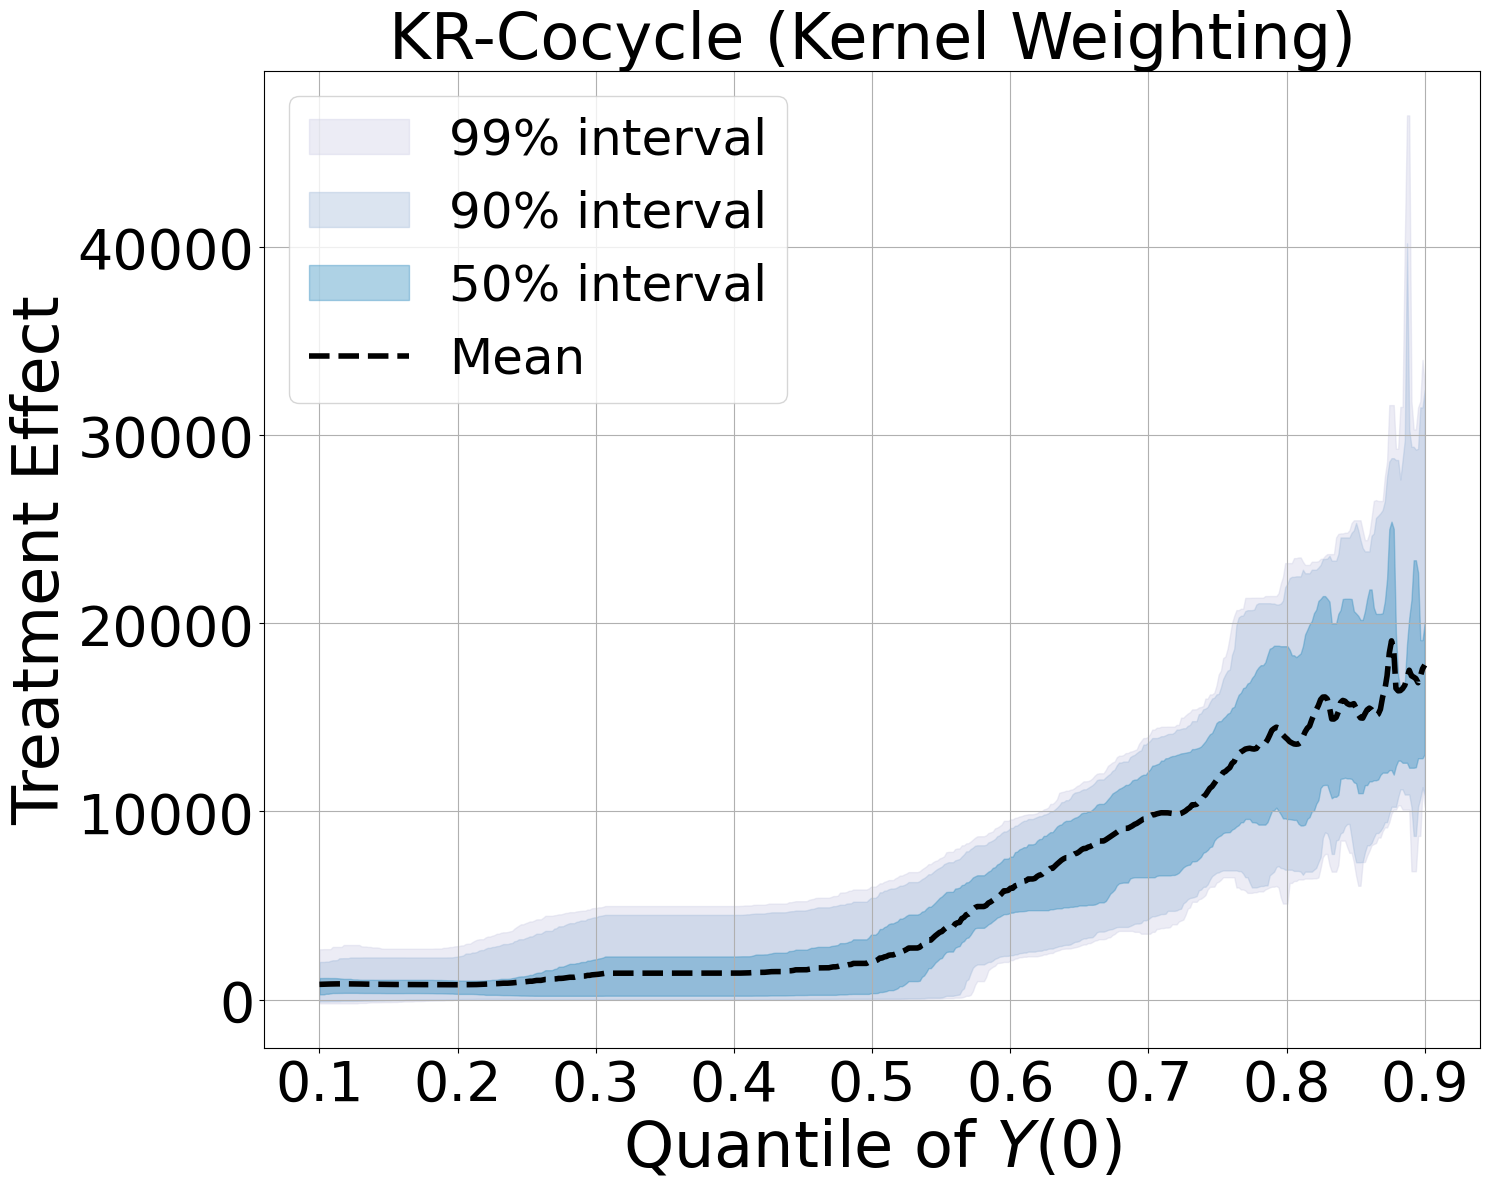

In [128]:
"""
Plotting Results
"""
import matplotlib.pyplot as plt

# Set up axis labels
x = torch.linspace(0.1, 0.9, ntest, dtype=torch.float64).numpy()
q = quantile_preds.detach().numpy()  # shape: (n_q, ntest)

# Define quantile levels for shaded regions
quantile_levels = [0.005, 0.05, 0.25, 0.5, 0.75, 0.95, 0.995]
qmap = {level: q[i] for i, level in enumerate(quantile_levels)}

# Create figure with doubled size
plt.figure(figsize=(15, 12))

# Fill between symmetric quantiles
fill_pairs = [(0.005, 0.995), (0.05, 0.95), (0.25, 0.75)]
colors = ['#d0d1e6', '#a6bddb', '#3690c0']  # lighter to darker

for (lo, hi), color in zip(fill_pairs, colors):
    plt.fill_between(x, qmap[lo]*scale_Y.item(), qmap[hi]*scale_Y.item(), alpha=0.4, color=color,
                     label=f'{int((hi - lo)*100+0.1)}% interval')

# Add the median quantile curve
plt.plot(x, mu_preds.detach()*scale_Y, color='black', lw=4.0, label='Mean', ls="dashed")

# Final formatting
plt.xlabel(r'Quantile of $Y(0)$', fontsize=46)
plt.ylabel('Treatment Effect', fontsize=46)
plt.title(r'KR-Cocycle (Kernel Weighting)', fontsize=46)
plt.legend(fontsize=36, loc = 'upper left')
plt.grid(True)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.tight_layout()
plt.savefig("e401k_krcocycle_kernel.png", bbox_inches = "tight")
plt.show()


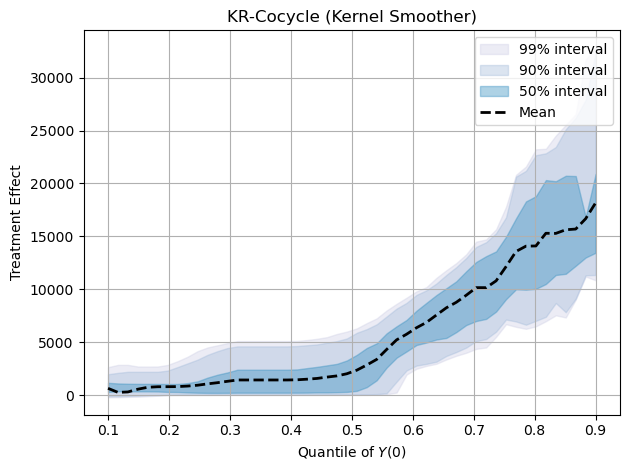

In [59]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.interpolate import make_interp_spline

# Set up axis labels
x = torch.linspace(0.1, 0.9, ntest, dtype=torch.float64).numpy()
q = quantile_preds.detach().numpy()  # shape: (n_q, ntest)

# Define quantile levels for shaded regions
quantile_levels = [0.005, 0.05, 0.25, 0.5, 0.75, 0.95, 0.995]
qmap = {level: q[i] for i, level in enumerate(quantile_levels)}

# Spline-smooth everything
x_smooth = np.linspace(x.min(), x.max(), ntest)
qmap_smooth = {}
for level in quantile_levels:
    spline = make_interp_spline(x, qmap[level], k=3)  # cubic spline
    qmap_smooth[level] = spline(x_smooth)

# Fill between symmetric quantiles
fill_pairs = [(0.005, 0.995), (0.05, 0.95), (0.25, 0.75)]
colors = ['#d0d1e6', '#a6bddb', '#3690c0']  # lighter to darker

for (lo, hi), color in zip(fill_pairs, colors):
    plt.fill_between(x_smooth, qmap_smooth[lo], qmap_smooth[hi],
                     alpha=0.4, color=color,
                     label=f'{int((hi - lo)*100+0.1)}% interval')

# Add the median quantile curve
plt.plot(x_smooth, mu_preds.detach(), color='black', lw=2.0,
         label='Mean', ls="dashed")

# Final formatting
plt.xlabel(r'Quantile of $Y(0)$')
plt.ylabel('Treatment Effect')
plt.title(r'KR-Cocycle (Kernel Smoother)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
import torch
from torch.distributions.normal import Normal

def conditional_kde_quantiles(x_query, x_train, y_train, x_kernel, y_bandwidth, quantiles):
    """
    Estimates conditional quantiles using kernel density estimation:
      - Kernel on x used for conditioning
      - Gaussian kernel on y used for smoothing the conditional density
      - Quantiles obtained by numerical inverse CDF (bisection)

    Args:
        x_query: (m, d) query points
        x_train: (n, d) training x
        y_train: (n,) training y
        x_kernel: function(x1, x2) → (m, n) kernel matrix
        y_bandwidth: float, bandwidth for Gaussian kernel on y
        quantiles: (q,) desired quantile levels

    Returns:
        quantile_preds: (q, m) tensor of estimated quantiles
    """
    m, n = x_query.shape[0], x_train.shape[0]
    q = quantiles.shape[0]

    # Step 1: Compute x-weights using kernel
    with torch.no_grad():
        K_x = x_kernel.get_gram(x_query, x_train)  # (m, n)
        weights = K_x / (K_x.sum(dim=1, keepdim=True) + 1e-8)  # normalize

    # Step 2: Define function to compute conditional CDF at a given y
    y_train = y_train.unsqueeze(0)  # (1, n)
    norm = Normal(loc=0.0, scale=y_bandwidth)

    def conditional_cdf(y_grid):  # y_grid: (m,) or (m,1)
        y_grid = y_grid.unsqueeze(-1)  # (m, 1)
        diffs = y_grid - y_train  # (m, n)
        cdfs = norm.cdf(diffs / y_bandwidth)  # (m, n)
        return (weights * cdfs).sum(dim=1)  # (m,)

    # Step 3: Invert the conditional CDF numerically for each quantile
    y_min = y_train.min().item() - 3 * y_bandwidth
    y_max = y_train.max().item() + 3 * y_bandwidth
    tol = 1e-4
    max_iter = 50

    quantile_preds = torch.zeros((q, m), dtype=torch.float64)

    for qi, tau in enumerate(quantiles):
        # Bisection for each point
        lb = torch.full((m,), y_min, dtype=torch.float64)
        ub = torch.full((m,), y_max, dtype=torch.float64)

        for _ in range(max_iter):
            mid = (lb + ub) / 2
            cdf_mid = conditional_cdf(mid)
            lb = torch.where(cdf_mid < tau, mid, lb)
            ub = torch.where(cdf_mid >= tau, mid, ub)
            if ((ub - lb) < tol).all():
                break

        quantile_preds[qi] = (lb + ub) / 2

    return quantile_preds

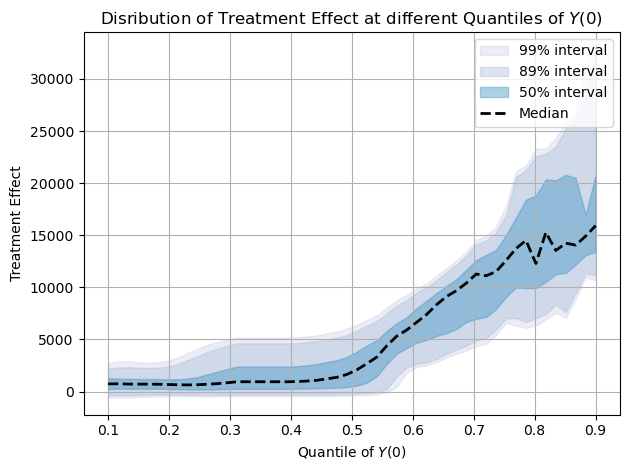

In [32]:
# Inputs
x_train = Y0sorted.unsqueeze(-1)  # (n, 1)
y_train = diff_sorted             # (n,)
x_query = Y0test.unsqueeze(-1)    # (m, 1)
quantiles = torch.tensor([0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975])
y_bandwidth = 20  # Can be tuned

# Define x-kernel (reuse your kernel)
quantile_preds_kde = conditional_kde_quantiles(
    x_query, x_train, y_train, kernel_, y_bandwidth, quantiles
)

import matplotlib.pyplot as plt

# Set up axis labels
x = torch.linspace(0.1, 0.9, ntest, dtype=torch.float64).numpy()
q = quantile_preds_kde.detach().numpy()  # shape: (n_q, ntest)

# Define quantile levels for shaded regions
quantile_levels = [0.005, 0.05, 0.25, 0.5, 0.75, 0.95, 0.995]
qmap = {level: q[i] for i, level in enumerate(quantile_levels)}

# Fill between symmetric quantiles
fill_pairs = [(0.005, 0.995), (0.05, 0.95), (0.25, 0.75)]
colors = ['#d0d1e6', '#a6bddb', '#3690c0']  # lighter to darker

for (lo, hi), color in zip(fill_pairs, colors):
    plt.fill_between(x, qmap[lo], qmap[hi], alpha=0.4, color=color,
                     label=f'{int((hi - lo)*100)}% interval')

# Add the median quantile curve
plt.plot(x, qmap[0.5], color='black', lw=2.0, label='Median', ls = "dashed")

# Final formatting
plt.xlabel(r'Quantile of $Y(0)$')
plt.ylabel('Treatment Effect')
plt.title(r'Disribution of Treatment Effect at different Quantiles of $Y(0)$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
import psutil, os
def cmmd_embedding_loss(model, X, Y, kernel, batchsize=10):
    """
    Computes the CMMD loss correctly via kernel trick:
      CMMD = (1/n) * sum_i || psi(Y_i) - (1/n) sum_j psi(T_{X_i,X_j}(Y_j)) ||^2
    without forming psi explicitly.

    Args:
        model: must have .cocycle(X_i, X_j, Y_j)
        X: (n, d)
        Y: (n, p)
        kernel: kernel object with get_gram(Y1, Y2)
        batchsize: number of outer-loop samples (i) to process

    Returns:
        scalar CMMD loss (torch tensor)
    """
    n = X.shape[0]
    device = X.device
    total_loss = 0.0
    with torch.no_grad():
        for i_start in range(0, n, batchsize):
            i_end = min(i_start + batchsize, n)
            b = i_end - i_start
    
            # Get batch of X_i and Y_i
            X_i = X[i_start:i_end]       # (b, d)
            Y_i = Y[i_start:i_end]       # (b, p)
    
            # Repeat X_i n times to match (i, j)
            X_i_repeat = X_i.unsqueeze(1).repeat(1, n, 1).reshape(b * n, -1)  # (b*n, d)
            X_j = X.repeat(b, 1)                                            # (b*n, d)
            Y_j = Y.repeat(b, 1)                                            # (b*n, p)
    
            # Apply transport: T_{X_i, X_j}(Y_j)
            Y_hat = model.cocycle(X_i_repeat, X_j, Y_j)  # (b*n, p)
            Y_hat = Y_hat.view(b, n, -1)  # (b, n, p)
    
            # --- Compute CMMD terms via kernel trick ---
    
            # Term 1: k(Y_i, Y_i)
            K_yy_diag = torch.diagonal(kernel.get_gram(Y_i, Y_i))  # (b,)
    
            # Term 2: (1/n^2) sum_{j,j'} k(Ŷ_{ij}, Ŷ_{ij'})
            K_hat_hat = torch.stack([
                kernel.get_gram(Y_hat[i], Y_hat[i]).mean()
                for i in range(b)
            ])  # (b,)
    
            # Term 3: (1/n) sum_j k(Y_i, Ŷ_{ij})
            K_y_hat = torch.stack([
                kernel.get_gram(Y_i[i:i+1], Y_hat[i]).mean()
                for i in range(b)
            ])  # (b,)
    
            # Combine terms
            loss_batch = K_yy_diag + K_hat_hat - 2 * K_y_hat
            total_loss += loss_batch.sum()
    
            print(f"Memory used (MB): {psutil.Process(os.getpid()).memory_info().rss / 1e6}")


    return total_loss / n

def cmmd_embedding_loss_optimized(model, X, Y, kernel, batchsize=10):
    """
    Computes CMMD loss:
        CMMD = (1/n) sum_i || ψ(Y_i) - (1/n) sum_j ψ(T_{x_i, x_j}(Y_j)) ||^2

    where T_{x_i, x_j}(Y_j) = f_{x_i} ( f_{x_j}^{-1}(Y_j) )

    Args:
        model: has .inverse_transformation(Y, X), .transformation(Y, X), .conditioner(X)
        X: (n, d)
        Y: (n, p)
        kernel: with .get_gram(A, B)
        batchsize: number of i's per batch

    Returns:
        scalar torch.Tensor
    """
    import gc, psutil, os

    n = X.shape[0]
    device = X.device
    total_loss = 0.0

    # ✅ Precompute base samples: f^{-1}_{x_j}(Y_j)
    print("Precomputing inverse-transformed base samples...")
    with torch.no_grad():
        Z_base = model.inverse_transformation(X, Y).detach()  # (n, p)

    for i_start in range(0, n, batchsize):
        i_end = min(i_start + batchsize, n)
        b = i_end - i_start

        X_i = X[i_start:i_end]     # (b, d)
        Y_i = Y[i_start:i_end]     # (b, p)
        loss_batch = torch.zeros(b, device=device)

        for i in range(b):
            xi = X_i[i:i+1]        # (1, d)
            yi = Y_i[i:i+1]        # (1, p)

            # Compute transported samples: T_{xi, xj}(Y_j) = f_{xi}(Z_base)
            xi_repeat = xi.repeat(n, 1)  # (n, d)
            with torch.no_grad():
                Y_hat = model.transformation(xi_repeat,Z_base).detach().unsqueeze(-1)  # (n, p)
            # Compute kernel terms
            k_yy = kernel.get_gram(yi, yi).item()
            k_hat_hat = kernel.get_gram(Y_hat, Y_hat).mean().item()
            k_y_hat = kernel.get_gram(yi, Y_hat).mean().item()

            loss_i = k_yy + k_hat_hat - 2 * k_y_hat
            loss_batch[i] = loss_i

        total_loss += loss_batch.sum()

        mem_MB = psutil.Process(os.getpid()).memory_info().rss / 1e6
        print(f"[{i_end}/{n}] Memory used (MB): {mem_MB:.2f}")
        gc.collect()
        torch.cuda.empty_cache()

    return total_loss / n

def cmmd_embedding_loss_vectorized(model, X, Y, kernel, batchsize=10):
    """
    Fully vectorized CMMD loss with batch processing over i.

    Args:
        model: with .inverse_transformation(X, Y), .transformation(X, Z)
        X: (n, d)
        Y: (n, p)
        kernel: with get_gram(A, B)
        batchsize: outer batch size

    Returns:
        scalar CMMD loss
    """
    import torch, gc, psutil, os

    n = X.shape[0]
    device = X.device
    total_loss = 0.0

    # Step 1: precompute base latent samples Z = f^{-1}_{x_j}(Y_j)
    print("Precomputing inverse-transformed base samples...")
    with torch.no_grad():
        Z_base = model.inverse_transformation(X, Y).detach()  # shape: (n, p)

    for i_start in range(0, n, batchsize):
        i_end = min(i_start + batchsize, n)
        b = i_end - i_start

        X_i = X[i_start:i_end]      # shape: (b, d)
        Y_i = Y[i_start:i_end]      # shape: (b, p)

        # Step 2: expand X_i to match (b x n) for transformation
        X_i_repeat = X_i[:, None, :].repeat(1, n, 1).reshape(b * n, -1)   # (b*n, d)
        Z_repeat = Z_base[None, :, :].repeat(b, 1, 1).reshape(b * n, -1)  # (b*n, p)

        # Step 3: transform → Y_hat[i, j, :] = f_{x_i}(Z_j)
        with torch.no_grad():
            Y_hat = model.transformation(X_i_repeat, Z_repeat).detach().reshape(b, n, -1)  # (b, n, p)

        # Step 4: Compute CMMD loss terms vectorized
        k_yy_diag = torch.diagonal(kernel.get_gram(Y_i, Y_i))  # (b,)
        k_y_hat = torch.stack([
            kernel.get_gram(Y_i[i:i+1], Y_hat[i]).mean()
            for i in range(b)
        ])
        k_hat_hat = torch.stack([
            kernel.get_gram(Y_hat[i], Y_hat[i]).mean()
            for i in range(b)
        ])

        loss_batch = k_yy_diag + k_hat_hat - 2 * k_y_hat
        total_loss += loss_batch.sum()

        mem_MB = psutil.Process(os.getpid()).memory_info().rss / 1e6
        print(f"[{i_end}/{n}] Memory used (MB): {mem_MB:.2f}")
        gc.collect()
        torch.cuda.empty_cache()

    return total_loss / n